# MNIST dataset classification using CNN
In this project a CNN (Convolution Neural Network) is used to classify an MNIST dataset. The architecture is similar to that of LeNet-5 explained by [Yann LeCun](yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) that is shown below:
<img src="lenet5.png" width="700" height="700" />

Now some the features of the Lenet-5 architecture is not exactly implementable in TensorFlow:
1. Trainable coefficients at the Pooling layer:
    1. The actual LeNet-5 architecture uses trainable coefficients at the pooling layers whereas this project simply uses a Max pooling layer
    
A stride of 1 is used for the convolution layers and stride of 2 is used for the pooling layers in this demo.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten

In [2]:
mnist=input_data.read_data_sets(".",one_hot=True,reshape=False)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


### Data Processing steps

In [3]:
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

print("Training samples: ",X_train.shape)
print("Validation samples: ",X_validation.shape)
print("Test samples: ",X_test.shape)

X_train=np.pad(X_train,((0,0),(2,2),(2,2),(0,0)),'constant')
X_validation=np.pad(X_validation,((0,0),(2,2),(2,2),(0,0)),'constant')
X_test=np.pad(X_test,((0,0),(2,2),(2,2),(0,0)),'constant')

print("\nAfter Padding:")
print("Training samples: ",X_train.shape)
print("Validation samples: ",X_validation.shape)
print("Test samples: ",X_test.shape)

from sklearn.utils import shuffle
X_train, y_train = shuffle( X_train, y_train)

def padding_shuffling(X,Y):
    X=np.pad(X,((0,0),(2,2),(2,2),(0,0)),'constant')
    X, Y = shuffle(X, Y)
    return (X,Y)

Training samples:  (55000, 28, 28, 1)
Validation samples:  (5000, 28, 28, 1)
Test samples:  (10000, 28, 28, 1)

After Padding:
Training samples:  (55000, 32, 32, 1)
Validation samples:  (5000, 32, 32, 1)
Test samples:  (10000, 32, 32, 1)


In [4]:
# Parameters
learning_rate = 0.001
epochs = 40
batch_size = 128
#test_valid_size=256   # Number of samples to calculate validation and accuracy
#dropout=0.75 $try using dropout in the design

In [5]:
x=tf.placeholder(tf.float32,[None, 32, 32, 1])
y1=tf.placeholder(tf.int32,[None])
y=tf.one_hot(y1,10)
keep_prob = tf.placeholder(tf.float32)

W={'wc1':tf.Variable(tf.random_normal([5,5,1,6],stddev=0.1)),
   'wp1':tf.Variable(tf.random_normal([6,1],stddev=0.1)),
   'wc2':tf.Variable(tf.random_normal([5,5,6,16],stddev=0.1)),
   'wp2':tf.Variable(tf.random_normal([16,1],stddev=0.1)),
   'wf1':tf.Variable(tf.random_normal([5*5*16,120],stddev=0.1)),
   'wf2':tf.Variable(tf.random_normal([120,84],stddev=0.1)),
   'wout':tf.Variable(tf.random_normal([84,10],stddev=0.1))
  }
biases={'bc1':tf.Variable(tf.random_normal([6])+0.1),
        'bp1':tf.Variable(tf.random_normal([6])+0.1),
        'bc2':tf.Variable(tf.random_normal([16])+0.1),
        'bp2':tf.Variable(tf.random_normal([16])+0.1),
        'bf1':tf.Variable(tf.random_normal([120])+0.1),
        'bf2':tf.Variable(tf.truncated_normal([84])+0.1),
        'bout':tf.Variable(tf.truncated_normal([10])+0.1)
       }

In [6]:
def conv_2d(x,w,b,stride=1):
    x=tf.nn.conv2d(x,w,strides=[1,stride,stride,1],padding='VALID')
    x=tf.nn.bias_add(x,b)
    return tf.nn.relu(x)
def pooling(x,w,b,k=2):
    #k is the ksize of the filter (for LeNet-5 k=5)
    return tf.nn.max_pool(x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='VALID')

In [7]:
def conv_NN(x,W,stride,biases,keep_prob):
    conv_layer1=conv_2d(x,W['wc1'],biases['bc1'],stride)
    conv_layer1=pooling(conv_layer1,W['wp1'],biases['bp1'])
    
    conv_layer2=conv_2d(conv_layer1,W['wc2'],biases['bc2'],stride)
    conv_layer2=pooling(conv_layer2,W['wp2'],biases['bp2'])
  
    fc1=flatten(conv_layer2)#try using this layer as convolution layer and not as fully connected layer
    fc1=tf.nn.bias_add(tf.matmul(fc1,W['wf1']),biases['bf1'])
    fc1=tf.nn.relu(fc1)
    fc1_drop = tf.nn.dropout(fc1, keep_prob)
    
    fc2=tf.nn.bias_add(tf.matmul(fc1_drop,W['wf2']),biases['bf2'])
    fc2=tf.nn.relu(fc2)
    
    logits=tf.nn.bias_add(tf.matmul(fc2,W['wout']),biases['bout'])
    return logits

In [8]:
logits=conv_NN(x,W,1,biases,keep_prob)
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
prediction=tf.equal(tf.arg_max(logits,1),tf.arg_max(y,1))
accuracy=tf.reduce_mean(tf.cast(prediction,tf.float32))

In [89]:
init=tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batchX,batchY=mnist.train.next_batch(batch_size=batch_size)
            batchX,batchY=padding_shuffling(batchX,batchY)
            """if epoch%100 == 0:
                train_accuracy = accuracy.eval(feed_dict={x:batchX, y: batchY, keep_prob: 1.0})
                print("step %d, training accuracy %g"%(epoch, train_accuracy))"""
            sess.run(optimizer,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
            #loss=sess.run(cost,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
        val_acc=sess.run(accuracy,feed_dict={x:X_validation,y:y_validation,keep_prob:1.0})
        print('Epoch {:>2}, Batch {:>3} -'
                'Validation Accuracy: {:.6f}'.format(
            epoch + 1,
            batch + 1,
            val_acc))
    test_accuracy=sess.run(accuracy,feed_dict={x:X_test,y:y_test,keep_prob:1.0})
    print('Testing Accuracy: {}'.format(test_accuracy))
    save_path = saver.save(sess, "MNIST_model.ckpt")
    print("Model saved in file: %s" % save_path)

Epoch  1, Batch 429 -Validation Accuracy: 0.955000
Epoch  2, Batch 429 -Validation Accuracy: 0.974800
Epoch  3, Batch 429 -Validation Accuracy: 0.978800
Epoch  4, Batch 429 -Validation Accuracy: 0.982400
Epoch  5, Batch 429 -Validation Accuracy: 0.983800
Epoch  6, Batch 429 -Validation Accuracy: 0.984400
Epoch  7, Batch 429 -Validation Accuracy: 0.986400
Epoch  8, Batch 429 -Validation Accuracy: 0.987600
Epoch  9, Batch 429 -Validation Accuracy: 0.988000
Epoch 10, Batch 429 -Validation Accuracy: 0.987800
Epoch 11, Batch 429 -Validation Accuracy: 0.987600
Epoch 12, Batch 429 -Validation Accuracy: 0.988200
Epoch 13, Batch 429 -Validation Accuracy: 0.988600
Epoch 14, Batch 429 -Validation Accuracy: 0.988000
Epoch 15, Batch 429 -Validation Accuracy: 0.989800
Epoch 16, Batch 429 -Validation Accuracy: 0.988600
Epoch 17, Batch 429 -Validation Accuracy: 0.989000
Epoch 18, Batch 429 -Validation Accuracy: 0.989200
Epoch 19, Batch 429 -Validation Accuracy: 0.987800
Epoch 20, Batch 429 -Validation

# Implementation Result
We can see that a test accuracy of 98.96% is acheived for this CNN. The architecture followed in this project is: 

Input Layer -> Conv -> Max Pooling -> Conv -> Max Pooling -> Fully Connected -> Fully Connected -> Output Layer

The parameters were as follows:

1. Learning rate= 0.001
2. Batch size   = 128
3. Optimizer    = Adam
4. Cost         = Softmax cross-entropy

Some of these parameters are studied in the following sections starting with learning rates. You can find the results at the end of the corresponding sections.

## 1. Variation in learning rate
In this section the learning rate is varied from 0.00001 to 0.1 on a logarithmic scale for the same architecture discussed above for (Epochs: 30, Batch sixe: 128) configuration to see its effect on the test accuracy of the network.

In [61]:
import math
lra=range(-5,0)
lr=list()
for i in lra:
    lr.append(pow(10,i))
print(lr)

[1e-05, 0.0001, 0.001, 0.01, 0.1]


In [62]:
test_accuracies=list()
for lrate in lr:
    x=tf.placeholder(tf.float32,[None, 32, 32, 1])
    y=tf.placeholder(tf.int32,[None,10])
    #y=tf.one_hot(y1,10)
    keep_prob = tf.placeholder(tf.float32)
    W={'wc1':tf.Variable(tf.random_normal([5,5,1,6],stddev=0.1)),
       'wp1':tf.Variable(tf.random_normal([6,1],stddev=0.1)),
       'wc2':tf.Variable(tf.random_normal([5,5,6,16],stddev=0.1)),
       'wp2':tf.Variable(tf.random_normal([16,1],stddev=0.1)),
       'wf1':tf.Variable(tf.random_normal([5*5*16,120],stddev=0.1)),
       'wf2':tf.Variable(tf.random_normal([120,84],stddev=0.1)),
       'wout':tf.Variable(tf.random_normal([84,10],stddev=0.1))
      }
    biases={'bc1':tf.Variable(tf.random_normal([6])+0.1),
            'bp1':tf.Variable(tf.random_normal([6])+0.1),
            'bc2':tf.Variable(tf.random_normal([16])+0.1),
            'bp2':tf.Variable(tf.random_normal([16])+0.1),
            'bf1':tf.Variable(tf.random_normal([120])+0.1),
            'bf2':tf.Variable(tf.truncated_normal([84])+0.1),
            'bout':tf.Variable(tf.truncated_normal([10])+0.1)
           }
    logits=conv_NN(x,W,1,biases,keep_prob)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=lrate).minimize(cost)
    prediction=tf.equal(tf.arg_max(logits,1),tf.arg_max(y,1))
    accuracy=tf.reduce_mean(tf.cast(prediction,tf.float32))
    init=tf.global_variables_initializer()
    with tf.Session() as sess1:
        sess1.run(init)
        for epoch in range(30):
            for batch in range(mnist.train.num_examples//batch_size):
                batchX,batchY=mnist.train.next_batch(batch_size=128)
                batchX,batchY=padding_shuffling(batchX,batchY)
                """if epoch%100 == 0:
                    train_accuracy = accuracy.eval(feed_dict={x:batchX, y: batchY, keep_prob: 1.0})
                    print("step %d, training accuracy %g"%(epoch, train_accuracy))"""
                sess1.run(optimizer,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
                #loss=sess.run(cost,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
                #val_acc=sess.run(accuracy,feed_dict={x:X_validation,y:y_validation,keep_prob:1.0})
                """print('Epoch {:>2}, Batch {:>3} -'
                      'Validation Accuracy: {:.6f}'.format(
                    epoch + 1,
                    batch + 1,
                    val_acc))"""
        test_accuracies.append(sess1.run(accuracy,feed_dict={x:X_test,y:y_test,keep_prob:1.0}))
        print("Learning rate: ",lrate," Completed")

Learning rate:  1e-05  Completed
Learning rate:  0.0001  Completed
Learning rate:  0.001  Completed
Learning rate:  0.01  Completed
Learning rate:  0.1  Completed


Learning rates:  [1e-05, 0.0001, 0.001, 0.01, 0.1]
Accuracies:  [0.90980017, 0.97860008, 0.99030012, 0.98400009, 0.1135]


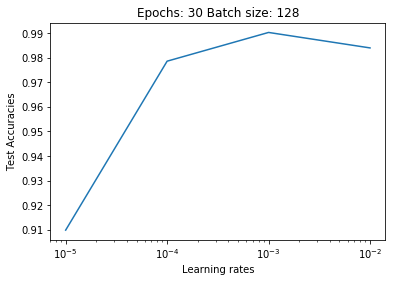

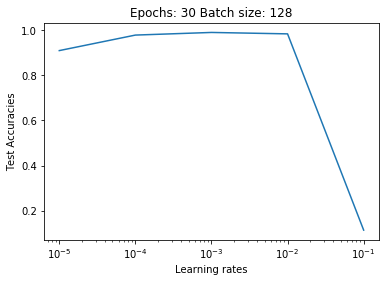

In [70]:
print("Learning rates: ",lr)
print("Accuracies: ",test_accuracies)

# Visualizing the data
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(lr[:4],test_accuracies[:4])
plt.xlabel("Learning rates")
plt.ylabel("Test Accuracies")
plt.title("Epochs: 30 Batch size: 128")
plt.show()

plt.semilogx(lr,test_accuracies)
plt.xlabel("Learning rates")
plt.ylabel("Test Accuracies")
plt.title("Epochs: 30 Batch size: 128")
plt.show()

### Result 1: Variation in learning rate
The first plot above is the zoomed version of the second plot. As we can see from the above two plots that increasing learning rates initially increases the test accuracy and then decreases it. Thsi is mainly because of the fact that slow learning rates takes lot of time to converge and yield a good accuracy and very high learning rates tend to diverge (instead of converging). Since we are running for only 30 epochs we are seeing a slightly lower accutacies for learning rates close to 0. The maximum test accuracy 0f 99.03% is noticed for learning rate=0.001 and there on incresing learning rate only worsens the accuracy. For very high learning rate of 0.1 we can see an accuracy of 11.35% which is very bad due to the divergence of the solution.

## 2. Variation in Batch Size
In this section the batch size is varied from 32 to 512 on a linear scale for the same architecture discussed above for (Epochs: 30, Lerning rate: 0.001) configuration to see its effect on the test accuracy of the network.

In [95]:
batch_sizes=[32,64,128,256,512]
test_accuracies2=list()
for b in batch_sizes:
    x=tf.placeholder(tf.float32,[None, 32, 32, 1])
    y=tf.placeholder(tf.int32,[None,10])
    #y=tf.one_hot(y1,10)
    keep_prob = tf.placeholder(tf.float32)
    W={'wc1':tf.Variable(tf.random_normal([5,5,1,6],stddev=0.1)),
       'wp1':tf.Variable(tf.random_normal([6,1],stddev=0.1)),
       'wc2':tf.Variable(tf.random_normal([5,5,6,16],stddev=0.1)),
       'wp2':tf.Variable(tf.random_normal([16,1],stddev=0.1)),
       'wf1':tf.Variable(tf.random_normal([5*5*16,120],stddev=0.1)),
       'wf2':tf.Variable(tf.random_normal([120,84],stddev=0.1)),
       'wout':tf.Variable(tf.random_normal([84,10],stddev=0.1))
      }
    biases={'bc1':tf.Variable(tf.random_normal([6])+0.1),
            'bp1':tf.Variable(tf.random_normal([6])+0.1),
            'bc2':tf.Variable(tf.random_normal([16])+0.1),
            'bp2':tf.Variable(tf.random_normal([16])+0.1),
            'bf1':tf.Variable(tf.random_normal([120])+0.1),
            'bf2':tf.Variable(tf.truncated_normal([84])+0.1),
            'bout':tf.Variable(tf.truncated_normal([10])+0.1)
           }
    logits=conv_NN(x,W,1,biases,keep_prob)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    prediction=tf.equal(tf.arg_max(logits,1),tf.arg_max(y,1))
    accuracy=tf.reduce_mean(tf.cast(prediction,tf.float32))
    init=tf.global_variables_initializer()
    with tf.Session() as sess1:
        sess1.run(init)
        for epoch in range(30):
            for batch in range(mnist.train.num_examples//b):
                batchX,batchY=mnist.train.next_batch(batch_size=b)
                batchX,batchY=padding_shuffling(batchX,batchY)
                """if epoch%100 == 0:
                    train_accuracy = accuracy.eval(feed_dict={x:batchX, y: batchY, keep_prob: 1.0})
                    print("step %d, training accuracy %g"%(epoch, train_accuracy))"""
                sess1.run(optimizer,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
                #loss=sess.run(cost,feed_dict={x:batchX,y:batchY,keep_prob:0.5})
                #val_acc=sess.run(accuracy,feed_dict={x:X_validation,y:y_validation,keep_prob:1.0})
                """print('Epoch {:>2}, Batch {:>3} -'
                      'Validation Accuracy: {:.6f}'.format(
                    epoch + 1,
                    batch + 1,
                    val_acc))"""
        test_accuracies2.append(sess1.run(accuracy,feed_dict={x:X_test,y:y_test,keep_prob:1.0}))
        print("Batch size: ",b," Completed")

Batch size:  32  Completed
Batch size:  64  Completed
Batch size:  128  Completed
Batch size:  256  Completed
Batch size:  512  Completed


Batch sizes:  [32, 64, 128, 256, 512]
Accuracies:  [0.98930013, 0.9898001, 0.98930013, 0.9891001, 0.98420012]


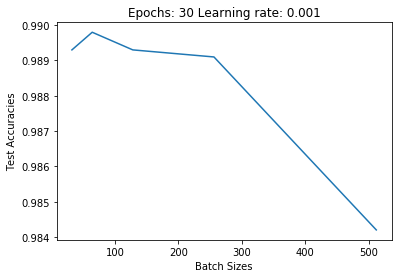

In [97]:
print("Batch sizes: ",batch_sizes)
print("Accuracies: ",test_accuracies2)

plt.plot(batch_sizes,test_accuracies2)
plt.xlabel("Batch Sizes")
plt.ylabel("Test Accuracies")
plt.title("Epochs: 30 Learning rate: 0.001")
plt.show()

### Result 2: Varation in batch size
We can see a decreasing trend in test accuracy with increasing batch size. This is expected because, if more training data is considered in a single forward/backward prop, weights update happen less frequently which means the network is not learning efficiently with in given number of epochs. Generally batches are used in cases when the memory requirement to train all the samples in a go is not met.

# Conclusion
The architecture results and the affect of some parameters on the prediction accuracy of the network are discussed in this demo. A test accuracy of nearly 99% is acheived for MNIST dataset using CNN with in just 40 epochs whereas the [Tensorflow tutorial](https://www.tensorflow.org/get_started/mnist/pros) acheived 99.2% after training the mdoel for 20000 epochs. This is mainly because of the smart choosing of the some of the hyperparameters like learning rate and batch size through above analysis.

Some more tweaks that can be done in this project as future work are as follows:
1. Changing the aarchitecture altogether:
    1. Changing the number of feature maps at every convolution layer
    2. Using different type of Pooling layers (Ex: avg_pool() etc.)
    3. Changing the strides and dimensions of the filters in all the convolution and pooling layers
2. Using several other optimizers such (Ex: GradientDescent, Adagrad, Momentum etc)
3. Using different type of cost functions (Ex: Least Mean square error, weighted cross-entropy etc)